## Sandbox for getting article pair similarity after filtering by named entities 

In [2]:
import pandas as pd
import numpy as np
from ast import literal_eval
import re
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial import distance 
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from tqdm import tqdm 
import networkx as nx
import pickle

In [3]:
#NOTE: very important, which entity categories to keep 
#article showing all entity types below
# https://www.kaggle.com/code/curiousprogrammer/entity-extraction-and-classification-using-spacy
TO_KEEP = ["org","event", "person", "work_of_art", "product"]
CLUSTER_CUTOFF = [2, 10000]
#for testing 

SIM_THRESH = .8
INVERTED_ENT_PATH = "/shared/3/projects/newsDiffusion/data/interim/NEREmbedding/invertedEntityIndex.pkl"
EMBEDS_PATH = "/shared/3/projects/newsDiffusion/data/processed/articleEmbeddings/embeddings.pkl"

CLEANED_DF_PATH = "/shared/3/projects/newsDiffusion/data/processed/newsData/fullDataWithNERCleaned.tsv"

In [4]:
#this is the df with our inverted index in it
invertedDf = pd.read_pickle(INVERTED_ENT_PATH)

In [5]:
print(f"len before filtering: {len(invertedDf)}")
invertedDf = invertedDf[(invertedDf["numArticles"] >= CLUSTER_CUTOFF[0]) & (invertedDf["numArticles"] <= CLUSTER_CUTOFF[1])]
print(f"len after filtering: {len(invertedDf)}")

len before filtering: 7436473
len after filtering: 2613960


In [6]:
#a dictionary so we can get the embeddings we need quickly 
#embeddingsDict = embeddingsDf.set_index("key").to_dict(orient="index")
embedsFile = open(EMBEDS_PATH, "rb")
embeddingsDict = pickle.load(embedsFile)

In [7]:
#get a list of the keys that correspond to each named entity 
#sort so that smaller clusters will be processed first :) 
keyOptions = list(invertedDf.sort_values("numArticles", ascending=False)["key"])

In [8]:
#sanity check, all of the embeddings are the proper length 
i = 0 
for key, val in embeddingsDict.items(): 
    if len(val["embedding"]) < 768: 
        print("broken") 

In [9]:
from sklearn.metrics.pairwise import cosine_similarity
entGroup = keyOptions[0]
myMat = np.matrix([embeddingsDict[key]["embedding"] for key in entGroup])

In [10]:
pairSims = cosine_similarity(myMat)

In [21]:
#a dictionary of pairs we've considered 
#compared = {i:{} for i in range(0, 6000000)}

outDict = {}
outList = []

#for each list of article keys associated with entities 
for i, entGroup in enumerate(tqdm(keyOptions)): 
    
    #within each list of article keys, consider the unique pairs 
    #and get their cosine similarities 
    #for i in range(0, len(entGroup)): 
    myMat = np.matrix([embeddingsDict[key]["embedding"] for key in entGroup])
    pairSims = cosine_similarity(myMat)
    
    for i, lKey in enumerate(entGroup):
        for j, rKey in enumerate(entGroup):
            sim = pairSims[i,j]
            if sim >= SIM_THRESH: 
                outDict[(lKey, rKey)] = sim

100%|██████████| 2613960/2613960 [4:30:50<00:00, 160.85it/s] 


In [23]:
compared = outDict

In [24]:
#turn our dictionary of article similarities into a dataframe for easier manipulation if need be 
pairsDf = pd.DataFrame.from_dict(compared, orient="index").reset_index()

pairsDf[["key1", "key2"]] = pairsDf["index"].tolist()

pairsDf = pairsDf.drop(columns="index")

pairsDf = pairsDf.rename(columns={0:"simScore"})

(array([11091776.,  8586892.,  6496276.,  4765864.,  3334812.,  2226804.,
         1519936.,  1254658.,  1978072.,  4442959.]),
 array([0.8 , 0.82, 0.84, 0.86, 0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 10 artists>)

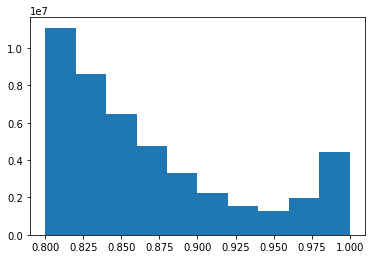

In [25]:
plt.hist(pairsDf["simScore"])

In [45]:
#overThresh = pairsDf[pairsDf["simScore"] >= SIM_THRESH]

BASE_PATH = "/shared/3/projects/newsDiffusion/data/interim/NEREmbedding/"
#OUT_PATHS = ["embeddingClusterDf_2_3000_83.tsv", "embeddingClusterDf_2_3000_85.tsv", "embeddingClusterDf_2_3000_87.tsv", "embeddingClusterDf_2_3000_9.tsv"]
#OUT_PATHS = [embeddingClusterDf_2_10000_90.tsv]
CUTOFFS = [.83, .85, .87, .90]

for i, cutoff in enumerate(tqdm(CUTOFFS)): 
    outPath = BASE_PATH + OUT_PATHS[i]
    overThresh = pairsDf[pairsDf["simScore"] >= cutoff]
    graph = nx.from_pandas_edgelist(overThresh[["key1", "key2"]], "key1", "key2")

    components = nx.connected_components(graph)
    compList = [comp for comp in components]

    clusters = pd.DataFrame({"cluster":compList}) #.reset_index()

    #we can remove clusters of size one 
    clusters["clustSize"] = clusters["cluster"].apply(lambda x: len(list(x)))

    clusters = clusters[clusters["clustSize"] > 1]

    clusters["clustNum"] = list(range(0, len(clusters)))

    clustDf = clusters.explode("cluster").rename(columns={"index":"clustNum", "cluster":"key"})

    clustSizes = pd.DataFrame(clustDf["clustNum"].value_counts()).reset_index()

    clustSizes.value_counts()
    
    clustDf.to_csv(outPath, sep="\t")

100%|██████████| 4/4 [05:12<00:00, 78.08s/it]


In [47]:
max(clustDf["clustSize"])

2335

(0.0, 5000.0)

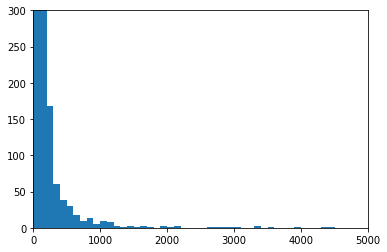

In [33]:
plt.hist(clustSizes["count"], bins=np.arange(0, 5000, 100))
plt.ylim(0, 300)
plt.xlim(0, 5000)

In [42]:
print(clustSizes.head())

   clustNum   count
0         3  335041
1       257   21645
2      1993    7793
3      5049    5071
4      1617    5024


In [35]:
clustDf.to_csv(OUT_PATH, sep="\t")